## Data preparation and preprocessing

## Preparing Data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Defining some variables

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
RGB = 3
EPOCHS = 50

Convering our dataset into a TensorFlow pipepline

In [3]:
#from tensorflow.python.ops.gen_array_ops import size
dataset_path = "/content/drive/MyDrive/PLD_3_Classes_256 - Copy"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4072 files belonging to 3 classes.


Classes of Potato leaf


In [4]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [5]:
# 128 batches, each batch is 32 images 
len(dataset)

128

Our data is now divided into batches of 32 images each


In [6]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0])
  print(label_batch.numpy())

tf.Tensor(
[[[215. 222. 250.]
  [215. 222. 250.]
  [215. 222. 250.]
  ...
  [207. 217. 253.]
  [207. 217. 253.]
  [207. 217. 253.]]

 [[215. 222. 250.]
  [215. 222. 250.]
  [216. 223. 251.]
  ...
  [207. 217. 253.]
  [207. 217. 253.]
  [207. 217. 253.]]

 [[216. 223. 251.]
  [216. 223. 251.]
  [216. 223. 251.]
  ...
  [207. 217. 253.]
  [207. 217. 253.]
  [207. 217. 253.]]

 ...

 [[146. 154. 191.]
  [148. 156. 193.]
  [150. 158. 195.]
  ...
  [144. 153. 194.]
  [145. 154. 195.]
  [145. 154. 195.]]

 [[147. 155. 192.]
  [148. 156. 193.]
  [149. 157. 194.]
  ...
  [144. 153. 194.]
  [144. 153. 194.]
  [145. 154. 195.]]

 [[149. 157. 194.]
  [149. 157. 194.]
  [148. 156. 193.]
  ...
  [143. 152. 193.]
  [144. 153. 194.]
  [145. 154. 195.]]], shape=(256, 256, 3), dtype=float32)
[0 1 1 2 0 0 1 2 2 2 0 2 2 0 1 0 0 0 2 1 2 2 2 2 0 1 0 0 0 0 2 0]


### Visualizing some data

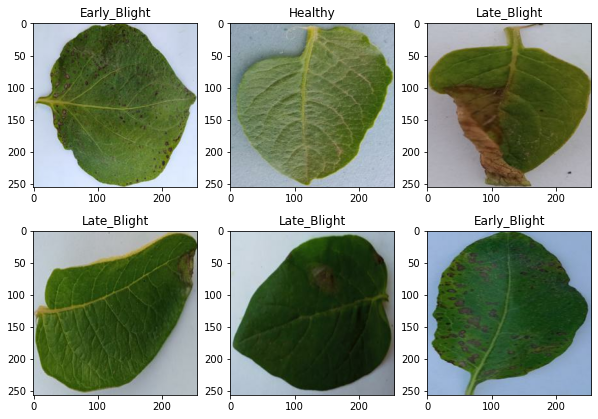

In [7]:
plt.figure(figsize=(10,7))
for image_batch, label_batch in dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
  

### Splitting data into Train, Validation and Test sets

In [8]:
def get_dataset_splits(ds, train_percentage=0.8, val_percentage=0.1, test_percentage=0.1, shuffle=True, shuffle_size=10000):
   
   ds_size = len(ds)

   if shuffle:
     ds = ds.shuffle(shuffle_size, seed=42)
   train_size = int(train_percentage * ds_size) 
   val_size = int(val_percentage * ds_size)
   #test_size = int(test_percentage * ds_size)

   train_ds = ds.take(train_size)
   val_ds = ds.skip(train_size).take (val_size) # take 10 percent of data after the end of train data
   test_ds = ds.skip(train_size).skip(val_size) #take the last 10 percent of data after the end of train data and validation data
   
   return train_ds, val_ds, test_ds

In [10]:
train, val, test = get_dataset_splits(dataset)
len(train), len(val), len(test)

(102, 12, 14)

Our data is splitted successfully!

###Caching the images to memory..Helps increase performance while training

In [11]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing Data

* Resizing our input data to a standard size of 256x256
* Rescaling pixels of images to have values between 0:1 instead of values 0:255

In [12]:
resize_rescale_layers = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_aug = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

## Building and Training The Model

### Building the model

In [14]:
n_classes = 3
model = tf.keras.Sequential([
    resize_rescale_layers,
    data_aug,
    tf.keras.layers.Conv2D(32, (3,3),activation="relu", input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, RGB)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, RGB))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (32, 516128)              0         
                                                                 
 dense (Dense)               (32, 64)                  33032256  
                                                      

## Compiling the model

In [16]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

## Training the model

In [17]:
history = model.fit(train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val, verbose=True)

Epoch 1/50
102/102 [==============================] - 416s 142ms/step - loss: 2.0202 - accuracy: 0.4892 - val_loss: 0.9458 - val_accuracy: 0.5156
Epoch 2/50
102/102 [==============================] - 8s 78ms/step - loss: 0.8494 - accuracy: 0.6201 - val_loss: 0.8397 - val_accuracy: 0.6328
Epoch 3/50
102/102 [==============================] - 7s 67ms/step - loss: 0.7491 - accuracy: 0.6809 - val_loss: 0.7570 - val_accuracy: 0.6615
Epoch 4/50
102/102 [==============================] - 7s 67ms/step - loss: 0.6408 - accuracy: 0.7373 - val_loss: 0.7122 - val_accuracy: 0.6667
Epoch 5/50
102/102 [==============================] - 7s 67ms/step - loss: 0.5920 - accuracy: 0.7685 - val_loss: 0.6997 - val_accuracy: 0.7109
Epoch 6/50
102/102 [==============================] - 7s 67ms/step - loss: 0.5531 - accuracy: 0.7716 - val_loss: 0.6278 - val_accuracy: 0.7526
Epoch 7/50
102/102 [==============================] - 7s 67ms/step - loss: 0.5137 - accuracy: 0.8000 - val_loss: 0.6071 - val_accuracy: 0.7

## Evaluating The model with Test data

In [18]:
scores = model.evaluate(test)

14/14 [==============================] - 7s 22ms/step - loss: 0.2187 - accuracy: 0.9286


Plotting Model history against Epochs

Text(0.5, 1.0, 'Training and Validation Accuracy')

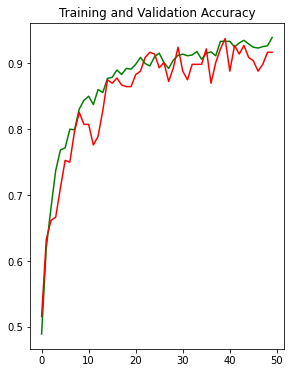

In [19]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10,6))

ax = plt.subplot(1, 2, 1)

plt.plot(range(EPOCHS), train_acc, c= "g", label="Train Accuracy")

plt.plot(range(EPOCHS), val_acc, c= "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")


##Making Some predictions

A function to make predicitions

In [20]:
def make_predictions(model, image):
  
  image_np = image.numpy()
  image_np = tf.expand_dims(image_np, 0) # to be in the input shape of the model [input_shape=(1, 256,256,3)] (a batch of only one image)

  prediction = model.predict(image_np)

  predicted_label = class_names[np.argmax(prediction)]
  confidence = round(np.max(prediction) * 100, 2)

  return predicted_label, confidence

Make predicitions and plot them against ground truth!

1/1 [==============================] - 0s 16ms/step


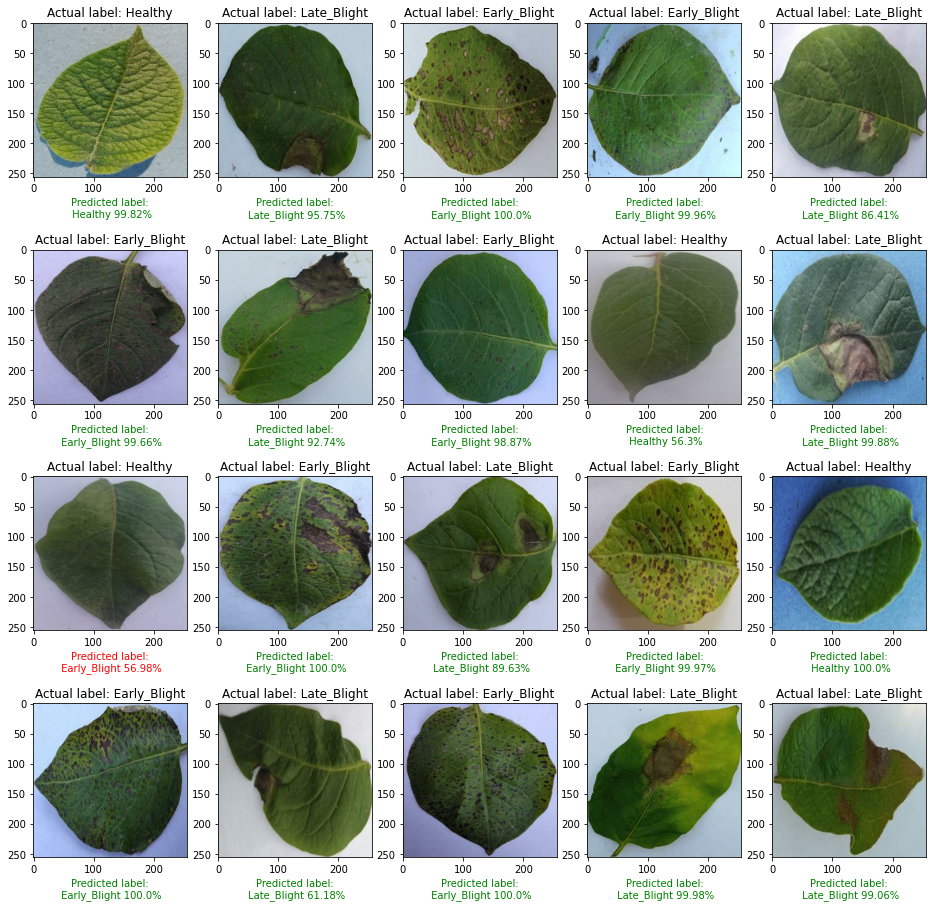

In [21]:
plt.figure(figsize=(16, 16))

for image_batch, batch_label in dataset.take(1):
  for i in range(20):
    
    ax = plt.subplot(4, 5, i+1)

    actual_label = class_names[batch_label[i]]
    
    predicted_label, confidence = make_predictions(model, image_batch[i])
    
    if actual_label == predicted_label:
      color = 'green'
    else:
      color = 'red'

    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Actual label: {actual_label}")
    plt.xlabel(f"Predicted label:\n {predicted_label} {confidence}%", color=color)

##Saving the model as H5 file

In [22]:
model.save("Model.h5")